Double Deep-Q Learning, обучение сети для игры в среде ViZDoom.



В лекции рассказывается про алгоритм Double Deep-Q Learning, где используются две нейронные сети - основная и целевая. Основная модель предсказывает значение по текущему состоянию среды, тем временем как целевая модель предсказывает значение по следующему состоянию среды.

В этом задании требуется испытать алгоритм где используется всего одна нейронная сеть. То есть, у вас должна быть только основная модель, которая предсказывает значение по текущему и по следующему состоянию. В конце ноутбука, напишите свой вывод про работоспособность такого алгоритма.

Сначала, скачиваем все нужные файлы для ViZDoom.

In [ ]:
import gdown #Импортируем модуль для скачивания датасетов

#Скачиваем файлы для ViZDoom
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/6_RL/rl.zip', output = None, quiet = True)
!unzip -qo rl.zip -d /Vizdoom/ #Разархивируем файлы

_____

Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нам нужно сначала установить различные дополнительные программы которые упомянаются в официальной документации.

In [ ]:
%%bash
#%%bash - значит используем командную строку (не код питона)
# Устанавливаем нужные программы, которая требует от нас документация: https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InR

Затем, устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

In [ ]:
#Обычно уходит 5-10 минут на установку этой библиотеки.
!pip install vizdoom==1.1.9

     |████████████████████████████████| 15.0 MB 6.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.9-py3-none-any.whl size=14084058 sha256=2a4592dea4811386d503a17757b4a4e146d1384c0aa2350fd03646659858f20a
  Stored in directory: /root/.cache/pip/wheels/89/75/34/2c03a5cc9d572ad08bed39e67bf0da279f63b03864a3aa2c66
Successfully built vizdoom


Подключаемся к диску и импортируем все нужные модули и библиотеки.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from vizdoom import *         #Импортируем все функции из cреды ViZDoom
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
from google.colab import output                                   #Импортируем функцию для управления вывода в колаб-ячейках

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2826240/45929032 bytes (6.2%)6471680/45929032 bytes (14.1%)10051584/45929032 bytes (21.9%)13901824/45929032 bytes (30.3%)17678336/45929032 bytes (38.5%)21184512/45929032 bytes (46.1%)24870912/45929032 bytes (54.2%)27795456/45929032 bytes (60.5%)30597120/45929032 bytes (66.6%)33071104/45929032 bytes (72.0%)35471360/45929032 bytes (77.2%)37855232/45929032 bytes (82.4%)

In [ ]:
# Ваш код

In [ ]:
def Make_DQN(input_shape, 
             action_size, 
             learning_rate):
  
  ''' Функция создания нейросети

      Args:
        input_shape -  
        action_size -  
        learning_rate - 
      
      Returns: возвращает готовую, компилированную модель
  
  '''
  model = Sequential()                                                                       
  model.add(Conv2D(32, 8, strides = (4,4), activation = 'relu', input_shape=(input_shape)))  
  model.add(Conv2D(64, 4, strides = (2,2), activation = 'relu'))                             
  model.add(Conv2D(64, 4, activation = 'relu'))
  model.add(Flatten())                                                                       
  model.add(Dense(512, activation = 'relu'))                                                                            
  model.add(Dense(action_size, activation = 'linear')) # Выходной слой должен иметь активационную функцию 'linear' — мы предсказываем награды на выходе НС.

  # Практика показывает, что RMSprop — хороший оптимизатор для обучения с подкреплением, однако можно использовать adam.
  optimizer = RMSprop(lr = learning_rate) 
  
  # Компилируем модель с функцией ошибки mse и заданным оптимизатором.
  model.compile(loss = 'mse', optimizer = optimizer) 

  return model     

In [ ]:
gamma = 0.95                         # Гамма   
observation_steps = 10000            # Количество шагов 

# Другие гиперпараметры

initial_epsilon = 1             # Начальное значение эпсилона (вероятность принять рандомный шаг)    
epsilon = initial_epsilon       # Текущее значение эпсилона (инициализируется как стартовое значение)
final_epsilon = 0.01            # Минимальное значение эпсилона (должен быть выше 0)
epsilon_decay_steps = 200000    # Мы будем уменьшать значение эпсилона на протяжении 200 000 шагов    
epsilon_decay_factor = (initial_epsilon - final_epsilon)/epsilon_decay_steps  # Задаем количество, на которое будем снижать эпсилон после каждого шага  

timesteps_per_train = 100       # Обучаем модель раз в 100 шагов (не обязательно ждать до конца игры)
learning_rate = 1e-4            # Обычно в обучении с подкреплением ставят низкий шаг обучения, например 1e-4
batch_size = 32                 # Используем размер пакета в 32    

In [ ]:
image_width = 64   # Ширина картинки (кадра)
image_height = 64  # Высота картинки (кадра)

num_frames = 4     # Количество последовательных кадров в одном состоянии (используется позже)

# Размерность каждого состояния — размер картинки:
state_shape = (image_width, image_height, num_frames) 

In [ ]:
def preprocess_frame(frame):
  
  ''' Функция преобразования изображений
      
      Args:
        frame - 

      Returns:
        Возвращаем предобработанное, нормализованное, решейпнутое изображение
  
  ''' 
  # Меняем оси:
  frame = np.rollaxis(frame, 0, 3) 
  
  # Меняем размерность картинки на (64×64):
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) 
  
  # Переводим в черно-белое:
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

  return frame.reshape(image_width, image_height, 1)/255 

In [ ]:
def get_reward(previous_info, 
               current_info, 
               episode_done):

    ''' Функция предобработки наград

        Args:
            previous_misc — информация об игровой среде на предыдущем кадре (количество убитых врагов, патроны и здоровье)
            current_misc — информация об игровой среде на текущем кадре (количество убитых врагов, патроны и здоровье)
            episode_done — булевое значение, которое говорит, если кадр последний в эпизоде.
            misc[0] — количество убитых врагов, misc[1] — патроны, misc[2] — здоровье
        
        Returns: подсчитанная награда
               
    '''   
    
    # Инициализируем награду как 0
    reward = 0     
    
    # Если кадр последний в игре, ставим награду как -0.1 и возвращаем ее (агент умер)
    if episode_done:                          
        reward = -0.1
        
        return reward
    
    # Если убили врага в кадре, увеличиваем награду на 1
    if current_info[0] > previous_info[0]:   
        reward += 1
    
    # Если потеряли здоровье, уменьшаем награду на 0.1
    if current_info[1] < previous_info[1]:   
        reward -= 0.1
    
    # Если использовали патрон, уменьшаем награду на 0.1
    if current_info[2] < previous_info[2]:   
        reward -= 0.1

    return reward  

In [ ]:
import random
def get_action(state, 
               epsilon, 
               action_size):
    
  ''' Функция предсказания награды за действие

      Args: state -
            epsilon - 
            action_size -

      Returns: выбранное действие и новое значение epsilon
  
  '''

  # Генерируем рандомное значение и сравниваем
  if random.random() <= epsilon:                     
    action_index = np.random.randint(0, action_size)  


  
  # Иначе (если рандомное число больше, чем эпсилон)
  else:                                              
    # Предсказываем все Q-значения при следующим действии (Q(s, a) для каждого действия a)
    Q_values = main_model.predict(np.expand_dims(state, axis = 0)) 
    # Извлекаем индекс действия который приводит к максимальному значению Q(s, a)
    action_index = np.argmax(Q_values)                             



  # Снижаем значение эпсилон, если оно больше, чем final_epsilon, снижаем значение epsilon на epsilon_decay_factor.
  if epsilon > final_epsilon:                        
    epsilon -= epsilon_decay_factor

  return action_index, epsilon                       

In [ ]:
# В памяти будет храниться не более 40 000 пар текущих и следующих состояний, действия которых нейронная сеть выбрала, а также их соответствующие награды
maximum_memory_length = 40000          

# Создаем буфер памяти
memory = deque([], maxlen = maximum_memory_length) 

In [ ]:
def add_to_memory(previous_state, 
                  action, 
                  reward, 
                  current_state, 
                  episode_done):
  
  ''' Функция записи информации в память
      
      Args:
        previous_state — массивы из состояния среды
        action — действие, которое было в нем принято
        reward — награда, которая была получена 
        current_state — следующее состояние, к которому действие привело 
        episode_done — булевое значение флагов окончания игры (кадр последний в эпизоде)

      Returns:
  '''
  
  # memory — глобальная переменная. Мы записываем в нее всю нужную информацию:
  memory.append((previous_state, action, reward, current_state, episode_done))  

In [ ]:
def sample_from_memory():

  ''' Функция сэмплирования данных
      
      Args: 

      Returns: распакованные данные
  '''     
  
  # Определим размер памяти: 
  memory_batch_size = min(batch_size * timesteps_per_train, len(memory))      
  
  # Сэмплируем данные:
  mini_batch = random.sample(memory, memory_batch_size) 

  # Создаем массив из нулей с размерностью предыдущих состояний, массива действий, массива наград, текущих состояний, флагов окончания игры
  previous_states = np.zeros((memory_batch_size, image_width, image_height, num_frames))   
  actions = np.zeros(memory_batch_size)                                                     
  rewards = np.zeros(memory_batch_size)                                                    
  current_states = np.zeros((memory_batch_size, image_width, image_height, num_frames))    
  episode_done = np.zeros(memory_batch_size)                                               

  # Перебираем данные и копируем их значения в массивы нулей:
  for i in range(memory_batch_size):                  
    previous_states[i, :, :, :] = mini_batch[i][0]  
    actions[i] = mini_batch[i][1]                   
    rewards[i] = mini_batch[i][2]                   
    current_states[i, :, :, :] = mini_batch[i][3]   
    episode_done[i] = mini_batch[i][4]             

  return previous_states, actions.astype(np.uint8), rewards, current_states, episode_done  

In [ ]:
def train_network(): 

  ''' Функция обучения алгоритма
      
      Args: 

      Returns: обученная модель
  '''        

  # Извлекаем пакет данных из памяти:
  previous_states, actions, rewards, current_states, game_finished = sample_from_memory()

  # Предсказываем Q(s, a):   
  Q_values = main_model.predict(previous_states)                                            
  
  # Предсказываем Q(s', a'):  
  next_Q_values = main_model.predict(current_states)                                      

  # Модифицируем значения Q: 
  for i in range(len(current_states)): 

    # Если состояние последнее в эпизоде:  
    if game_finished[i]:               
      Q_values[i, actions[i]] = rewards[i]
    # Если состояние не последнее в эпизоде: 
    else: 
      Q_values[i, actions[i]] = rewards[i] + gamma * next_Q_values[i, actions[i]] 

  # Обучаем модель: 
  main_model.fit(previous_states, Q_values, batch_size = batch_size, verbose = 0) 

In [ ]:
def show_scores(scores, 
                killcount, 
                ammo):

  ''' Функция визуализации результата
      
      Args:
        scores -  
        killcount -  
        ammo -

      Returns: график
  '''     

  # Удаляем предыдущий вывод ячейки:
  output.clear() 

  # Создаем два сабплота (в левом будут награды и средние награды, в правом будут количества убитых врагов и патронов): 
  fig, axes = plt.subplots(1, 2, figsize = (20, 8)) # Делаем размер графика большим

  # Устанавливаем большой размер полотна:
  axes[0].plot(scores, label = "Награда за эпизод")                          
  # Отрисовываем скользящие средние награды:
  axes[0].plot(moving_average(scores), label = "Скользящее среднее награды") 
  # Добавляем лейблы осей:
  axes[0].set_xlabel("Итерация", fontsize = 16)                              
  axes[0].set_ylabel("Награда", fontsize = 16)
  # Добавляем легенду к графику:
  axes[0].legend()                                                           

  # Отрисовываем количество убитых врагов:
  axes[1].plot(killcount, 'red', linestyle = '--', label = "Количество убитых врагов (сумма за 10 эпизодов)")              
  # Отрисовываем количество убитых врагов (скользящее среднее):
  axes[1].plot(moving_average(killcount), 'black', label = "Количество убитых врагов (скользящее среднее за 10 итераций)") 
  # Отрисовываем количество оставшихся патронов:
  axes[1].plot(ammo, 'green', linestyle = '--', label = "Осталось патронов (сумма за 10 эпизодов)")                        
  # Отрисовываем количество оставшихся патронов (скользящее среднее):
  axes[1].plot(moving_average(ammo), 'blue', label = "Осталось патронов (скользящее среднее за 10 итераций)")              
  # Добавляем лейблы осей:
  axes[1].set_xlabel("Итерация", fontsize = 16)  
  axes[1].set_ylabel("Значение", fontsize = 16)
  # Добавляем легенду к графику:
  axes[1].legend()                               

  # Отображаем график:
  plt.show()   

In [ ]:
def moving_average(data, 
                   width = 10): 
  
  ''' Функция для подсчета скользящего среднего всех значений
      
      Args:
        data — входной массив, 
        width — длина, на которую считаем скользящее среднее
      
      Returns: результат свертки данных на фильтр из единиц — наше скользящее среднее 
  '''

  # Длина свертки:  
  width = min(width, len(data))    

  # Создадим паддинг для свертки:  
  data = np.concatenate([np.repeat(data[0], width), data])         
  
  # Возвращаем результат свертки: 
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  

In [ ]:
!ls /Vizdoom/scenarios/

basic.cfg	       defend_the_line.cfg	     my_way_home.wad
basic.wad	       defend_the_line.wad	     oblige.cfg
bots.cfg	       health_gathering.cfg	     predict_position.cfg
cig.cfg		       health_gathering_supreme.cfg  predict_position.wad
cig.wad		       health_gathering_supreme.wad  README.md
cig_with_unknown.wad   health_gathering.wad	     rocket_basic.cfg
deadly_corridor.cfg    learning.cfg		     rocket_basic.wad
deadly_corridor.wad    multi.cfg		     simpler_basic.cfg
deathmatch.cfg	       multi_deathmatch.wad	     simpler_basic.wad
deathmatch.wad	       multi_duel.cfg		     take_cover.cfg
defend_the_center.cfg  multi_duel.wad		     take_cover.wad
defend_the_center.wad  my_way_home.cfg


In [ ]:
# Инициализируем среду:
game = DoomGame() 

# Загружаем сценарий «Защищай центр»:
game.load_config("/Vizdoom/scenarios/defend_the_center.cfg") #Загружаем сценарий «Защищай центр»

# Устанавливаем размер кадров среды (будет 640×480):
game.set_screen_resolution(ScreenResolution.RES_640X480) 

# Нужно отключить окно, чтобы не было ошибки:
game.set_window_visible(False) 

# Инициализируем игру:
game.init() 

# Извлекаем количество возможных уникальных действий:
action_size = game.get_available_buttons_size()                 
print(action_size)
# Создаем основную модель (будет обучаться):
main_model = Make_DQN(state_shape, action_size, learning_rate)   
main_model.summary()
# Создаем целевую сеть (не будет обучаться, периодически будет обновляться под основную модель):
#target_model = Make_DQN(state_shape, action_size, learning_rate) 

# Устанавливаем параметры целевой модели (копируем в нее значения основной модели):
#update_target_model()                                           

# Устанавливаем количество кадров за каждое действие. Нам не нужен каждый кадр, 
# поэтому будем совершать действие и брать новое состояние лишь раз в 4 кадра:
frames_per_action = 4  

3
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 15, 32)        8224      
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 64)          32832     
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          65600     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               295424    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 403,619
Trainable params: 403,619
Non-

In [ ]:
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/6_RL/vizdoom_DQN_stats.txt', None,quiet=True)
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/6_RL/vizdoom_DQN_model.h5', None,quiet=True)


'vizdoom_DQN_model.h5'

In [ ]:
load_pretrained = False #Решаем, если мы обучаем модель с нуля или продолжаем предыдущую сессию обучения

#Если хотим продолжить текущее обучение, загружаем сохраненные веса для основной и целевой моделей:
if load_pretrained:
  main_model.load_weights('/content/vizdoom_DQN_model.h5')
  #target_model.load_weights('/content/vizdoom_DQN_model.h5')
  #Также загружаем ранее сохраненные статистики из pickle файла:
  with open('/content/vizdoom_DQN_stats.txt', 'rb') as f:
    record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon = pickle.load(f)

#Иначе мы просто инициализируем списки, в которых будет храниться статистика о работе агента:
else:
  record_rewards = []          #Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            #Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            #Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     #Инициализируем номер эпизода как 1
  timestep = 0           #Инициализируем номер шага как 0

In [ ]:
# Генерируем новый эпизод:
game.new_episode()

# Извлекаем первый кадр (это еще не полноценное состояние):                        
game_data = game.get_state()    
print(game_data)
# Извлекаем информацию об игре (количество убитых врагов, патроны, здоровье):
current_info = game_data.game_variables   
print(current_info)
# Записываем информацию о текущем моменте как 'предыдущий' момент (чтобы потом мы могли сравнить разницу):
previous_info = current_info             

# Извлекаем кадр из игры (480×640):
frame = game_data.screen_buffer 
print(frame.shape)                                                      
# Предобрабатываем кадр в черно-белый (размер 64×64):
processed_frame = preprocess_frame(frame)                                             

# В качестве первого состояния просто дублируем кадр 4 раза:
current_state = np.stack([processed_frame.reshape(64, 64)] * num_frames, axis = 2)    
# Инициализируем предыдущий шаг как текущий шаг:
previous_state = current_state  

# Инициализируем награды:

interval_reward = 0  # за интервал (10 эпизодов) как 0
interval_kills = 0   # за количество убитых врагов (10 эпизодов) как 0
interval_ammos = 0   # за количество оставшихся патронов (10 эпизодов) как 0

[  0.  26. 100.]
(3, 480, 640)


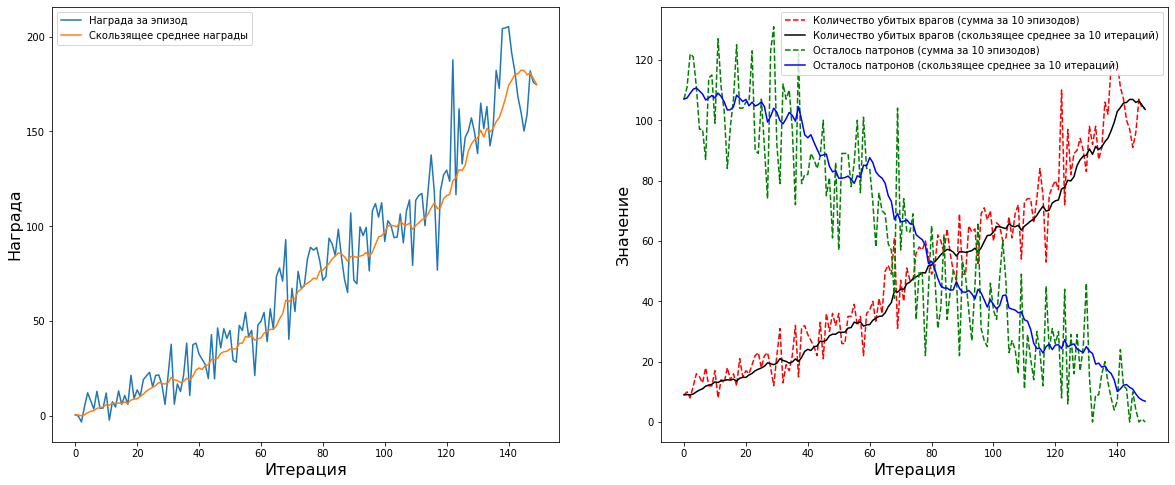

Статистика успешно сохранена.


In [ ]:
while episode_number<1500:
  
  # Увеличиваем номер шага на 1:
  timestep += 1 
  # Извлекаем индекс награды и новое значение эпсилон:
  action_index, epsilon = get_action(previous_state, epsilon, action_size)  
  # Приводим награду в onehot массив:
  action_onehot = to_categorical(action_index)                              
  # Подаем действие в игровую среду в качестве списка: 
  game.set_action(action_onehot.tolist())                                   
  # Игра продвигается на 4 кадра (значение frames_per_action):
  game.advance_action(frames_per_action)                                    

  # Предобрабатываем кадр в черно-белый (размер 64×64×1):
  game_data = game.get_state()                                    

  # Проверяем, если эпизод закончился:
  episode_done = game.is_episode_finished() 

  # Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод:
  if episode_done: 
    print(f"Закончился {episode_number}-й эпизод. Значение эпсилон: {round(epsilon, 2)}, Количество убитых врагов: {current_info[0]}, количество оставшихся патронов: {current_info[1]}")

    episode_number += 1   # Увеличиваем номер эпизода на 1:
    interval_kills += current_info[0]
    interval_ammos += current_info[1]

    # Чтобы не собирать слишком много данных и чтобы их было удобно отображать на графике

    # Записываем результат раз в 10 эпизодов:
    if episode_number % 10 == 0 and episode_number > 0: 
      
      # Добавляем награду в список всех наград:
      record_rewards.append(interval_reward)            
      # Добавляем количество убитых врагов:
      record_kills.append(interval_kills)               
      # Добавляем количество неиспользованных патронов:
      record_ammos.append(interval_ammos)               
      # Записываем результаты в графики:
      show_scores(record_rewards, record_kills, record_ammos)  

      # Сохраняем веса модели:
      main_model.save_weights('/content/drive/MyDrive/NN/vizdoom_DQN_model.h5') 
      
      # Записываем статистику в файл через библиотеку pickle:
      with open('/content/drive/MyDrive/NN/vizdoom_DQN_stats.txt', 'wb') as f:  
        pickle.dump([record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon], f) 
      print("Статистика успешно сохранена.")

      # Заново инициализируем значения статистики для интервала в 10 эпизодов:
      interval_reward, interval_kills, interval_ammos = 0, 0, 0 

    # Начинаем новый эпизод игры:
    game.new_episode()                       
    # Извлекаем новое состояние игры:
    game_data = game.get_state()             

  # Извлекаем информацию об игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровье):
  current_info = game_data.game_variables   
  # Извлекаем новый кадр из игры:
  frame = game_data.screen_buffer           
  # Предобрабатываем кадр (новая размерность будет 64×64×1):
  processed_frame = preprocess_frame(frame)    
  # Обновляем состояние — удаляем последний кадр и добавляем новый:
  current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) 

  # Извлекаем награду за шаг из среды (логика, которую не можем менять):
  environment_reward = game.get_last_reward()                           
  # Извлекаем награду за шаг из самописной функции (самописная награда, значит, можем менять логику):
  custom_reward = get_reward(previous_info, current_info, episode_done) 
  # Общая награда — это сумма награды из среды и самописной награды:
  reward = environment_reward + custom_reward 

  # Добавляем награду в переменную для статистики:
  interval_reward += reward 

  # Добавляем предыдущее состояние, действие, награду и текущее состояние в память:
  add_to_memory(previous_state, action_index, reward, current_state, episode_done) 
  
  # Обучаем нашу модель раз в 100 шагов, но только если у нас достаточно данных в памяти:
  if timestep % timesteps_per_train == 0 and len(memory) > observation_steps: 
    train_network()

  # Обновляем целевую модель весами основной модели раз в заданное количество (5 000) шагов:
  #if timestep % target_model_update_frequency == 0: 
  #  update_target_model()

  # Запоминаем предыдущую информацию:
  previous_info = current_info    
  # Запоминаем предыдущее состояние:
  previous_state = current_state  